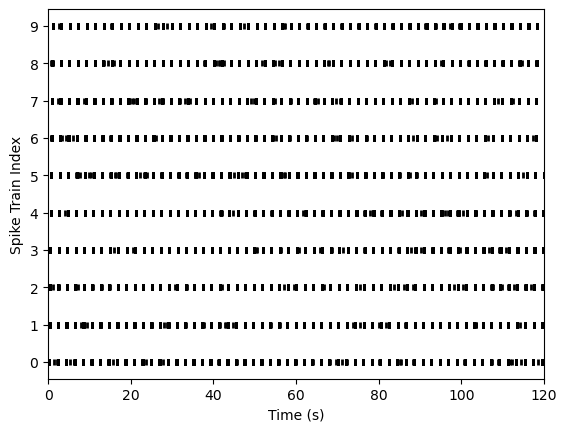

In [2]:
import MEArec as mr
import matplotlib.pyplot as plt
import neo
import quantities as pq
from pathlib import Path
import numpy as np
import os
import numpy as np
import h5py



# PARAMETRI DI SIMULAZIONE
duration = 120                # Durata della simulazione (in secondi)
t_start = 0                   # Tempo di inizio (s)
n_spikes_per_burst = 12       # Numero di spike per ogni burst
intra_burst_isi = 0.005       # Intervallo intra-burst (5 ms)
burst_duration = intra_burst_isi * (n_spikes_per_burst - 1)  # ≈ 0.035 s
inter_burst = 2               # Intervallo tra burst (in secondi)
n_mixed_neurons = 10          # Numero di neuroni simulati
n_isolated_spikes = 20       # Numero di spike isolati per neurone

# Liste per contenere spike train e tipi cellulari
spike_times = []
cell_types = []

# Funzione che controlla se un tempo cade all’interno di un burst
def in_burst(t, burst_intervals):
    return any(start <= t <= end for start, end in burst_intervals)

# Generazione dei dati per ogni neurone
for neuron_idx in range(n_mixed_neurons):
    st = np.array([])                              # Inizializza vettore degli spike
    burst_start = 0.2 + 0.1 * neuron_idx           # Inizio primo burst (diverso per ogni neurone)
    burst_times = []                               # Lista per tenere traccia degli intervalli di burst

    # Genera tutti i burst finché c'è spazio nella simulazione
    while burst_start < duration - burst_duration:
        burst = burst_start + np.arange(n_spikes_per_burst) * intra_burst_isi  # Spike regolari nel burst
        jitter = np.random.normal(0, 0.003, size=n_spikes_per_burst)           # Jitter gaussiano ±1 ms
        burst += jitter                                                        # Applica jitter
        st = np.concatenate((st, burst))                                       # Aggiunge il burst allo spike train
        burst_times.append((burst_start, burst_start + burst_duration))       # Salva l'intervallo del burst
        burst_start += burst_duration + inter_burst                           # Avanza all'inizio del burst successivo

    # Genera spike isolati che non cadono nei burst
    isolated_spikes = []
    attempts = 0
    while len(isolated_spikes) < n_isolated_spikes and attempts < 1000:
        candidate = np.random.uniform(0, duration)              # Prova uno spike casuale
        if not in_burst(candidate, burst_times):                # Se non cade in un burst, accetta
            isolated_spikes.append(candidate)
        attempts += 1

    # Unisce spike burst + isolati, ordina e rimuove duplicati
    st = np.concatenate((st, isolated_spikes))
    st = np.sort(np.unique(st))

    spike_times.append(st)                 # Aggiunge allo spike train globale
    cell_types.append('E')                # Etichetta (es. 'E' come neurone eccitatorio)

# Crea gli oggetti SpikeTrain di Neo
spike_trains = []
for i, st in enumerate(spike_times):
    spiketrain = neo.SpikeTrain(
        times=st * pq.s,                  # Spike in secondi
        t_start=t_start * pq.s, 
        t_stop=duration * pq.s
    )
    spiketrain.annotate(cell_type=cell_types[i])  # Aggiunge attributo 'cell_type'
    spike_trains.append(spiketrain)

# Crea oggetto MEArec per usare il plot_rasters
spgen = mr.SpikeTrainGenerator(spiketrains=spike_trains)

# Mostra il raster plot (opzionale)
_ = mr.plot_rasters(spgen.spiketrains, cell_type=False)


# Salva gli spike train in un file h5
with h5py.File('../templates/spiketrains.h5', 'w') as f:
    for i, st in enumerate(spike_times):
        f.create_dataset(f'neuron_{i}', data=st)


template_filename = Path('templates_tetrodes.h5')


template_params = mr.get_default_templates_params()
cell_folder = mr.get_default_cell_models_folder()


template_params['probe'] = 'tetrode'
template_params['n'] = 5


#tempgen = mr.gen_templates(cell_models_folder=cell_folder, params=template_params, verbose=False)


#mr.save_template_generator(tempgen, template_filename)

template_filename = '../templates/templates.h5'




In [ ]:

rec_params = mr.get_default_recordings_params()
rec_params['recordings']['noise_level'] = 5
rec_params['recordings']['filter'] = False
rec_params['recordings']['bursting'] = True
rec_params['recordings']['exp_decay'] = [0.1, 0.7]
rec_params['recordings']['max_burst_duration'] = 800
rec_params['recordings']['bursting_units'] = [0, 1]
rec_params['templates']['min_dist'] = 0.5
rec_params["templates"]["min_amp"] = 100
rec_params["templates"]["max_amp"] = 150
rec_params["templates"]["xlim"] = [-9, 9]





recgen = mr.gen_recordings(params=rec_params, spgen=spgen, templates=template_filename, verbose=False)

mr.plot_recordings(recgen, overlay_templates=False, lw=0.5)

spike_traces = recgen.spike_traces


#
# Plotting the spike traces
# fig, ax = plt.subplots(figsize=(10, 6))
mr.save_recording_generator(recgen, filename="../templates/recordings.h5")   


In [ ]:
# finding sampling frequency
rec = mr.load_recordings("../templates/recordings.h5")
print(rec)  # prova a vedere la struttura
print(rec.params['recordings']['fs'])

import h5py
import numpy as np

filename = '../templates/spiketrains.h5'

with h5py.File(filename, 'w') as f:
    for i, st in enumerate(spgen.spiketrains):
        # Salvo i tempi degli spike in secondi come array numpy
        f.create_dataset(str(i), data=st.times.rescale('s').magnitude)
